# **Face Mask Detection Project 😷**
**Final Project** | **Data Science & AI Diploma** - **December 2025**

---

## **1. Introduction 💡** 

### A. Overview

In the wake of recent global health challenges, particularly the COVID-19 pandemic, wearing face masks has become an essential and mandatory preventative measure in public and enclosed spaces. Governments and health organizations have enforced these policies to curb the transmission of airborne viruses.

### B. The Problem

Enforcing these policies and effectively monitoring compliance with mask-wearing protocols presents a significant challenge, especially in high-traffic areas such as shopping malls, airports, and public transportation hubs. Continuous manual monitoring is costly, labor-intensive, and prone to human error.

### C. The Proposed Solution

This is where Artificial Intelligence, specifically **Computer Vision**, plays a critical role. By developing an automated system, we can leverage existing surveillance cameras to analyze video streams or images in real-time to identify individuals who are not complying with mask-wearing guidelines.

### D. Project Objective

**The primary objective of this Notebook** is to build and train a deep learning model capable of:
1.  **Detecting** human faces within an image or video frame (Face Detection).
2.  **Classifying** each detected face accurately into one of two categories: **"With Mask"** or **"Without Mask"**.

## 📂 **About this Data**
* https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
* This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.
* All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset.

## **2. Import Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import os
import random
import glob as gb
import threading


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import scikit-learin
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import OPEN_CV
import cv2

# Import tensorflow
import tensorflow as tf

# Using Keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import regularizers, layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.video import VideoStream

## **3. Data Exploration & Loading**

### Data Exploration

In [31]:
train_dir = r'E:/Omar/Courses/AMIT-main/Final Project of AI/PLAN D (Face Mask Detection)/Dataset/archive_2/Face Mask Dataset/Train'
validation_dir = r"E:/Omar/Courses/AMIT-main/Final Project of AI/PLAN D (Face Mask Detection)/Dataset/archive_2/Face Mask Dataset/Validation"
test_dir = r'E:/Omar/Courses/AMIT-main/Final Project of AI/PLAN D (Face Mask Detection)/Dataset/archive_2/Face Mask Dataset/Test'

In [ ]:
# To get the list of all files and directories in the specified directory.
for folder in os.listdir(train_dir):
    
    images = gb.glob(pathname=str(train_dir + '/' + folder + '/*.png'))
    print(f'Traning Data, found {len(images)} Images in {folder} Folder')

Traning Data, found 5000 Images in WithMask Folder
Traning Data, found 5000 Images in WithoutMask Folder


In [ ]:
# To get the list of all files and directories in the specified directory.
for folder in os.listdir(validation_dir):
    
    images = gb.glob(pathname=str(validation_dir + '/' + folder + '/*.png'))
    print(f'Traning Data, found {len(images)} Images in {folder} Folder')

Traning Data, found 400 Images in WithMask Folder
Traning Data, found 400 Images in WithoutMask Folder


In [ ]:
# To get the list of all files and directories in the specified directory.
for folder in os.listdir(test_dir):
    
    images = gb.glob(pathname=str(test_dir + '/' + folder + '/*.png'))
    print(f'Traning Data, found {len(images)} Images in {folder} Folder')

Traning Data, found 483 Images in WithMask Folder
Traning Data, found 509 Images in WithoutMask Folder


### Data Visualization

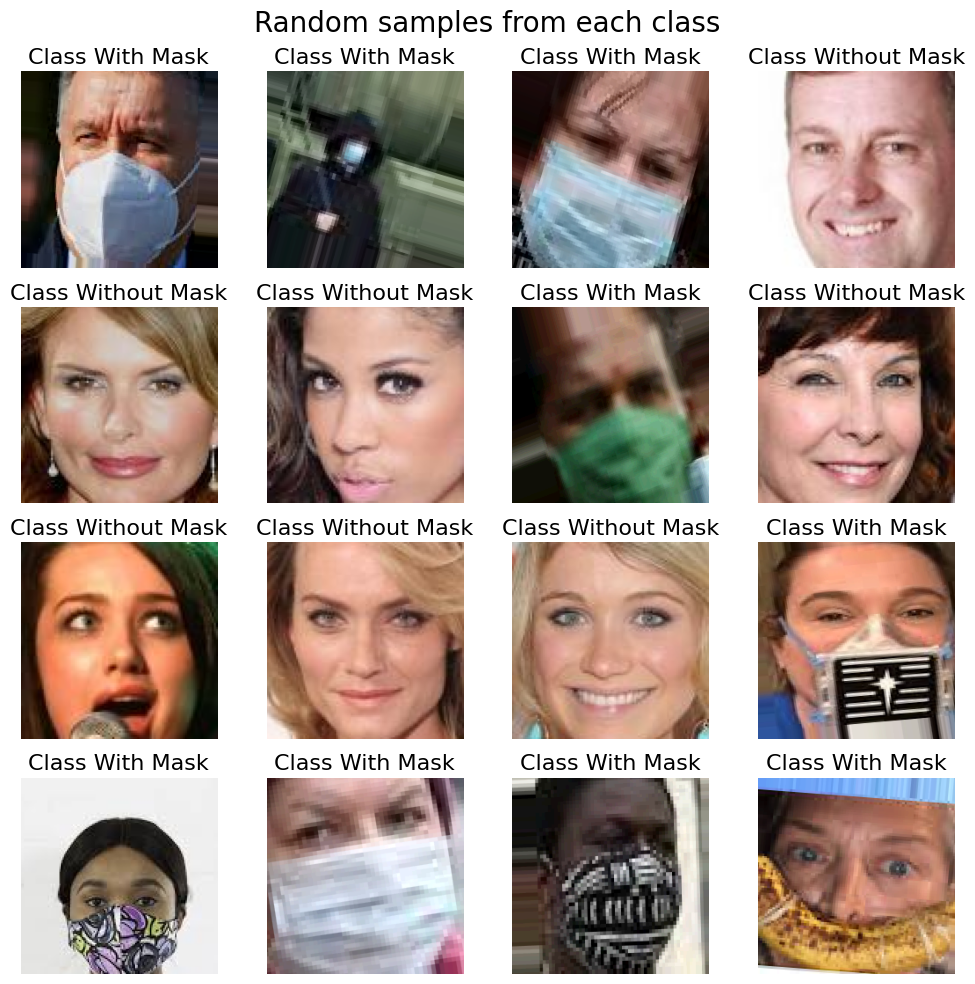

In [ ]:
# Define a mapping dictionary to convert numeric labels to class names
classes_name = {
                0 : 'With Mask', 
                1 : 'Without Mask'
}

# Get the list of class folders (categories) from the training directory
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

# Define the grid layout for visualization (4 rows x 4 columns)
row = 4
cols = 4
all_img = row * cols        # Total number of images to display (16)

plt.figure(figsize=(10, 10))
# Loop to generate and display random samples
for i in range(all_img):
    
    # Select a random class index (0 or 1)
    random_index = random.randint(0, num_classes-1)
    # Get the folder name and the corresponding display name
    Class = classes[random_index]       # 'WithMask' or 'WithoutMask'
    class_name_str = classes_name[random_index]
    
    # Construct the full path to the selected class folder
    class_path = os.path.join(train_dir, Class)
    # Pick a random image file from that specific class folder
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    # Convert image from BGR (OpenCV default) to RGB (Matplotlib requirement)
    # This ensures colors appear correctly in the plot
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create a subplot for the current image index
    plt.subplot(row, cols, i+1)
    plt.imshow(img)
    # Set the title as the class name and remove axis ticks for cleaner look
    plt.title(f'Class {class_name_str}', fontsize=16)
    plt.axis('off')

# Add a main title and adjust layout to prevent overlap
plt.suptitle("Random samples from each class", fontsize=20)
plt.tight_layout()
plt.show()

### Data Loading

#### Apply Data Augmantation

In [36]:
# Defining the constants (image dimensions and batch size)
# (It is very important that all images are the same size)
img_width = 224
img_height = 224
batch_size = 32

# Creating a training generator (with data augmentation)
# (Data augmentation helps the model not to memorize images and to generalize better)
train_datagen = ImageDataGenerator(

        rescale= 1./255,              # Normalization: Divides each pixel by 255
        rotation_range= 20,           # Rotates the image by up to 20 degrees
        width_shift_range= 0.2,       # Moves the image horizontally
        height_shift_range= 0.2,      # Moves the image vertically
        shear_range= 0.2,             # Crops the image
        zoom_range=0.3,               # Zooms in
        horizontal_flip = True,       # Flips the image horizontally
        fill_mode= 'nearest'
)

# Create a validation and test generator (we only perform normalization)
# (It is very important not to augment the evaluation data)
test_val_datagen = ImageDataGenerator(rescale= 1./255)

In [37]:
# Downloading the training data from folders
train_generator = train_datagen.flow_from_directory(
    
    train_dir,
    target_size= (img_width, img_height),
    batch_size= batch_size,
    class_mode= 'binary'      # 'binary' because there are only 2 classes (Mask/NoMask)
)

# Downloading the validation data from folders
validation_generator = test_val_datagen.flow_from_directory(
    
    validation_dir,
    target_size= (img_width, img_height),
    batch_size= batch_size,
    class_mode= 'binary'      # 'binary' because there are only 2 classes (Mask/NoMask)
)

# Downloading the testing data from folders
test_generator = test_val_datagen.flow_from_directory(
    
    test_dir,
    target_size= (img_width, img_height),
    batch_size= batch_size,
    class_mode= 'binary',      # 'binary' because there are only 2 classes (Mask/NoMask)
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Creat The Model

This function builds a custom model on top of a pre-trained model (Transfer Learning).

**Inputs:**

- base_model: The base model without the Top layer (include_top=False).

- use_flatten: (Boolean) To specify the dimensional reduction method, either Flatten or GlobalAveragePooling.

**Outputs:**

- model: The final model, compiled and ready for training.

In [ ]:
def build_model(base_model, use_flatten=False):
    
    # We stop training the base model weights to retain the information it has already learned (such as edge and shape detection).
    # This speeds up training and reduces the need for large datasets.
    base_model.trainable = False
    
    # Receiving the outputs of the basic model
    x = base_model.output
    
    # If use_flatten=True, we use Flatten (converting the array to a single line - this may cause overfitting).
    # Otherwise, we use GlobalAveragePooling2D (averaging - better for reducing parameters and generalizing the model).
    x = Flatten()(x) if use_flatten else GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)                         # We randomly turn off 30% of the cells to prevent the model from saving data (Overfitting prevention).
    x = Dense(128, activation='relu')(x)        # A hidden layer containing 128 neurons to learn patterns related to new data. The ReLU activation function is used because it is fast and prevents the vanishing gradient problem.
    x = Dropout(0.3)(x)                         # We randomly turn off 30% of the cells to prevent the model from saving data (Overfitting prevention).
    output = Dense(1, activation='sigmoid')(x)  # Only one cell because the classification is binary.
    
    model = Model(inputs=base_model.input, outputs=output)
    
    """
    Compile Model:
    
    - Optimizer: (Adam).
    - Loss Function: ('binary_crossentropy' for Binary Classification problems).
    - Metrics: (accuracy).
    
    """
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Early Stoping
EarlyStopping is one of the most important "Callbacks" in Keras. Its function is to monitor the model's training and automatically stop it when it stops improving, saving time and protecting the model from the problem of "overfitting".

- `monitor`               ==> We ask the code to monitor the "Validation Loss" value.
- `patience`              ==> It is the number of attempts (Epochs) that the model waits for before deciding to stop.
- `restore_best_weights`  ==> Retrieve the best: When training stops (for example, at cycle 50), the model's best performance may have been at cycle 40.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### `ReduceLROnPlateau`

Simply put, it is a tool that monitors the model's performance, and if it finds that the performance is no longer improving, it automatically reduces the learning rate.
As the model approaches the optimal solution, it sometimes needs to "slow down" a bit (reduce its step) to reach the optimal point. Callback does this automatically instead of you having to do it yourself.

- `monitor`  ==> We ask the code to monitor the "Validation Loss" value.
- `factor`   ==> Reduction factor: This number determines "how much will we reduce the speed?"
- `patience` ==> The number of cycles (Epochs) that we will wait and see consistent performance before deciding to reduce the Learning Rate.

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

### Train the Model

Train the model using `model.fit()` on training and validation data.

### ResNet50

In [41]:
resnet = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)))
history_resnet = resnet.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[reduce_lr, early_stop])
print(f'ResNet50 Accuracy: {history_resnet.history["accuracy"][-1]}')

Epoch 1/20
313/313 [==============================] - 87s 270ms/step - loss: 0.6960 - accuracy: 0.5560 - val_loss: 0.6508 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 83s 265ms/step - loss: 0.6549 - accuracy: 0.5940 - val_loss: 0.6399 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 86s 276ms/step - loss: 0.6499 - accuracy: 0.6026 - val_loss: 0.6126 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 93s 298ms/step - loss: 0.6445 - accuracy: 0.6090 - val_loss: 0.6141 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 93s 298ms/step - loss: 0.6333 - accuracy: 0.6299 - val_loss: 0.5971 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 95s 304ms/step - loss: 0.6301 - accuracy: 0.6349 - val_loss: 0.5823 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 7/20
313/313 [==============================] 

### VGG16

In [42]:
vgg = build_model(VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)), use_flatten=True)
history_vgg = vgg.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[reduce_lr, early_stop])
print(f'VGG16 Accuracy: {history_vgg.history["accuracy"][-1]}')

Epoch 1/20
313/313 [==============================] - 100s 317ms/step - loss: 0.2061 - accuracy: 0.9303 - val_loss: 0.0319 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 98s 312ms/step - loss: 0.0981 - accuracy: 0.9641 - val_loss: 0.0252 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 97s 310ms/step - loss: 0.0895 - accuracy: 0.9680 - val_loss: 0.0177 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 96s 306ms/step - loss: 0.0743 - accuracy: 0.9734 - val_loss: 0.0175 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 96s 308ms/step - loss: 0.0696 - accuracy: 0.9749 - val_loss: 0.0201 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 98s 313ms/step - loss: 0.0670 - accuracy: 0.9777 - val_loss: 0.0254 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 7/20
313/313 [==============================]

### MobileNetV2

In [43]:
mobilenet = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)))
history_mobilenet = mobilenet.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[reduce_lr, early_stop])
print(f'MobileNetV2 Accuracy: {history_mobilenet.history["accuracy"][-1]}')

Epoch 1/20
313/313 [==============================] - 95s 296ms/step - loss: 0.1239 - accuracy: 0.9496 - val_loss: 0.0299 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 92s 293ms/step - loss: 0.0770 - accuracy: 0.9735 - val_loss: 0.0287 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 91s 292ms/step - loss: 0.0732 - accuracy: 0.9741 - val_loss: 0.0260 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 91s 289ms/step - loss: 0.0623 - accuracy: 0.9769 - val_loss: 0.0260 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 92s 294ms/step - loss: 0.0614 - accuracy: 0.9785 - val_loss: 0.0291 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 97s 309ms/step - loss: 0.0595 - accuracy: 0.9782 - val_loss: 0.0297 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/20
313/313 [==============================] 

In [44]:
loss_train, accuracy_train = mobilenet.evaluate(train_generator)
loss_val, accuracy_val = mobilenet.evaluate(validation_generator)

print(f"Train Loss: {loss_train}")
print(f"Train Accuracy: {accuracy_train}")
print('==================================')
print(f"Validation Loss: {loss_val}")
print(f"Validation Accuracy: {accuracy_val}")

25/25 [==============================] - 1s 54ms/step - loss: 0.0191 - accuracy: 0.9925
Train Loss: 0.021125709637999535
Train Accuracy: 0.9925000071525574
Validation Loss: 0.019106917083263397
Validation Accuracy: 0.9925000071525574


### Visualize Training History

Plot **accuracy** and **loss** curves for both training and validation data **across epochs**. This helps diagnose problems such as **overfitting** or **underfitting**.

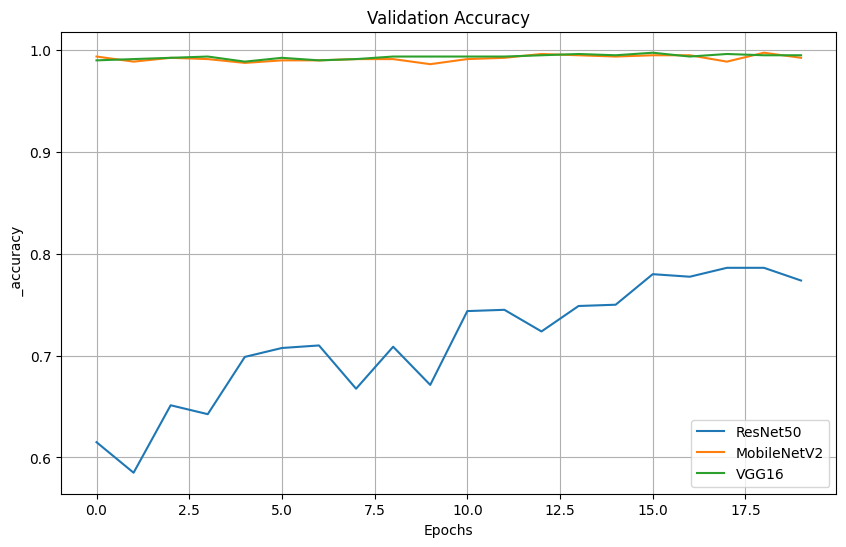

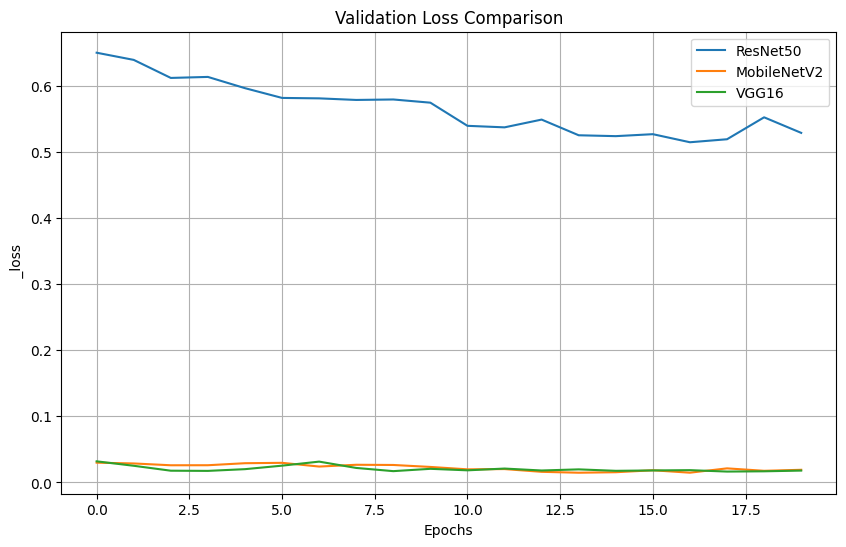


 Model Comparison Table:

      Model  Validation Accuracy  Validation Loss
   ResNet50                77.38           0.5294
MobileNetV2                99.25           0.0191
      VGG16                99.50           0.0179


In [ ]:
def plot_metrics(histories, labels, metric='val_accuracy', title='Validation Accuracy'):
    
    plt.figure(figsize=(10,6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=label)
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('val', ' ').capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(
    [history_resnet, history_mobilenet, history_vgg],
    ['ResNet50', 'MobileNetV2', 'VGG16'],
    metric='val_accuracy',
    title='Validation Accuracy'
)

plot_metrics(
    [history_resnet, history_mobilenet, history_vgg],
    ['ResNet50', 'MobileNetV2', 'VGG16'],
    metric='val_loss',
    title='Validation Loss Comparison'
)

results = []
labels = ['ResNet50', 'MobileNetV2', 'VGG16']
histories = [history_resnet, history_mobilenet, history_vgg]

for label, history in zip(labels, histories):
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({'Model': label, 'Validation Accuracy': round(val_acc * 100, 2), 'Validation Loss': round(val_loss, 4)})

results_df = pd.DataFrame(results)
print("\n Model Comparison Table:\n")
print(results_df.to_string(index=False))

### 📊 Model Training Results Summary

In this project, we trained and compared three different Deep Learning models using **Transfer Learning** to solve the **Face Mask Detection** classification problem. The tested models are:

1.  **ResNet50**
2.  **MobileNetV2**
3.  **VGG16**

All models were trained for **20 Epochs**. Below are the performance details and the final comparison:

#### 1\. Performance Comparison Table

| Model Name | Training Accuracy | Validation Accuracy | Validation Loss | Observation |
| :--- | :---: | :---: | :---: | :--- |
| **ResNet50** | 67.4% | 77.3% | 0.5294 | Low performance, suffered from underfitting/instability due to **Preprocessing Mismatch** (Requires Caffe Style). |
| **MobileNetV2** | **98.7%** | **99.2%** | **0.0191** | **Best Fit**. Achieved the perfect balance between high accuracy and speed. Ideal for **Real-time** applications. |
| **VGG16** | 98.71% | 99.5% | 0.0179 | Highest accuracy numerically, but the model size is massive (Overkill), resulting in high latency and computational cost. |

-----

#### 2\. Results Analysis

##### 🏆 Selected Model: MobileNetV2

  * **Performance:** Achieved high accuracy on the validation set (**99.2%**) with the lowest loss (**0.0191**).
  * **Efficiency:** MobileNetV2 is a **Lightweight** model, making it the fastest in terms of **Inference Time**.
  * **Conclusion:** It is the most suitable model for **Face Mask Detection**, as it can run efficiently on surveillance cameras (CCTV) or mobile devices without consuming excessive resources.

##### 📉 Observations on Other Models

  * **VGG16:** Despite achieving excellent accuracy, its computational cost is very high. Using it for this specific task is considered "Overkill" and inefficient for deployment.
  * **ResNet50:** It showed the weakest performance (77.3%). This is technically attributed to the **Preprocessing Mismatch**; it requires specific image standardization (Zero-centering/BGR) rather than simple rescaling.


-----

#### 3\. Final Conclusion

Based on the criteria of Accuracy, Speed, and Model Size, **MobileNetV2** has been adopted as the final model for this project.

> **Next Step:** The model will be evaluated on the **Test Set** and deployed for **Live Video Stream** detection.

In [47]:
mobilenet.save("MobileNetV2.h5")

### Testing & Evaluating The Model
Calculating Accuracy and Loss (Evaluate)

In [3]:
model = load_model('MobileNetV2.h5')

In [49]:
print('Evaluating MobileNetV2 on Test Set...')

test_loss, test_acc = model.evaluate(test_generator)

print(f"\nTest Accuracy: {test_acc * 100:.2f} %")
print(f"Test Loss: {test_loss:.2f}")

Evaluating MobileNetV2 on Test Set...
31/31 [==============================] - 3s 51ms/step - loss: 0.0152 - accuracy: 0.9929

Test Accuracy: 99.29 %
Test Loss: 0.02


Creating predictions to generate reports

In [50]:
# We expect results for all images in the Test Set.
preds = model.predict(test_generator)

# Converting predictions from probabilities of (0.2, 0.9) to 0 or 1 (based on a threshold of 0.5)
pred_classes = (preds > 0.5).astype('int32')

# Get the real ratings
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

31/31 [==============================] - 2s 48ms/step


Confusion Matrix

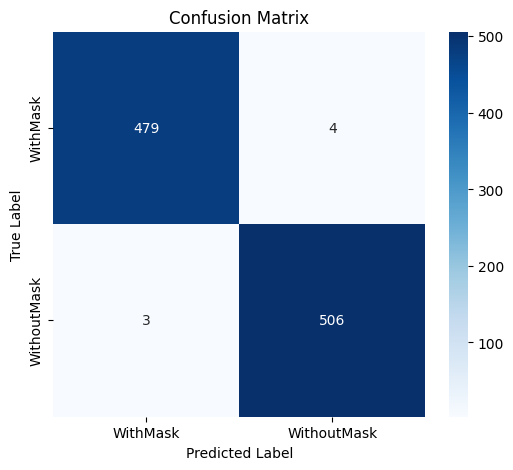

In [52]:
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [ ]:
# Load the pre-trained Caffe model for face detection
# 1. prototxt: Defines the model architecture (layers)
# 2. caffemodel: Contains the trained weights
face_net = cv2.dnn.readNetFromCaffe(
    r"E:/Omar/Courses/AMIT-main/Final Project of AI/PLAN D (Face Mask Detection)/deploy.prototxt",
    r"E:/Omar/Courses/AMIT-main/Final Project of AI/PLAN D (Face Mask Detection)/res10_300x300_ssd_iter_140000.caffemodel"
)

# ============================================================
# Threaded Video Capture (to improve performance and reduce lag)
# ============================================================
class VideoStream:
    def __init__(self, src):
        self.stream = cv2.VideoCapture(src)                       # Open the video source (camera/IP Webcam/file)
        self.ret, self.frame = self.stream.read()                 # Reading the first frame to prepare the variables and Return value (True or False)
        self.stopped = False                                      # A control variable to stop the thread
        thread = threading.Thread(target=self.update, args=())    # Create a thread running in the background to execute the update() function
        thread.daemon = True                                      # Make the thread daemon close automatically when the program is closed
        thread.start()                                            # Run the thread
    
    def update(self):
        # Continuous loop for reading frames without interruption and in the background
        while not self.stopped:
            self.ret, self.frame = self.stream.read()
    
    def read(self):
        # Return to the last captured frame (always updated from the thread)
        return self.frame
    
    def stop(self):
        # Stop the thread and close the camera
        self.stopped = True
        self.stream.release()


# ============================================================
# Turn on IP Webcam
# ============================================================
ip = "http://192.168.1.7:8080/video"
stream = VideoStream(ip)

print("Starting optimized IP Webcam stream...")



while True:
    frame = stream.read()
    
    if frame is None:
        continue
    
    # Reduce frame rate to increase speed
    frame = cv2.resize(frame, (640, 480))
    
    # Extracting frame dimensions ((height, width, channels))
    # It is later used to convert DNN coordinates from normalized to actual pixels.
    h, w = frame.shape[:2]
    
    
    # It converts the image (frame) into a blob, which is the format needed by the DNN (Caffe Face Detection Network) model.
    # blob ==> It is an image that has been: Resized, Reordered, Meaned (subtracted) and Prepared to feed into the neural model, So that the input is ready for use within.
    """
    frame ==> Camera image
    1.0 ==> scalefactor
    (300, 300) ==> This is the required image size for the model.
    (104.0, 177.0, 123.0) ==> (BGR) These are the Mean subtraction values. The Caffe network was trained on data to which the same process was applied.
    """
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # Give the model the picture that he will analyze.
    face_net.setInput(blob)
    # This is the line that actually activates the Face Detector.
    # detections = [Batch Size, Class Label, Detections, Data Info]
    detections = face_net.forward()
    
    # Passing over each detected face
    # detections.shape[2] = Number of faces detected.
    for i in range(0, detections.shape[2]):
        
        
        # Caffe models like res10_300x300_ssd when you forward, return the result in the form of a (4D Array), like this: [Batch Size, Class Label, Detections, Data Info]
        """ 
        Why [0, 0, i, 2]?
        
        - The first zero [0]: This is the batch number. Since we're working on one image (or frame) at a time, we always select image number 0 (the first one).
        - The second zero [0]: This is the class label. In this particular model, this field is reserved and not being used, so we use 0.
        - The variable i: This is the number of the discovered face. The model might find 5 faces, so i iterates through them one by one (face 1, 2, 3...).
        - The last number (and the most important): This specifies what information you want about this face. For each discovered face, the model returns 7 numbers (information) consecutively.
        """
        """
        - 0 ==> Batch ID
        - 1 ==> Class ID
        - 2 ==> Confidence
        - 3 ==> Start X (xmin)
        - 4 ==> Start Y (ymin)
        - 5 ==> End X (xmax)
        - 6 ==> End Y (ymax)
        """
        confidence = detections[0, 0, i, 2]
        
        # If confidence is low → ignore the face.
        if confidence < 0.5:
            continue
        
        """
        The output of the Caffe face detector returns the coordinates as follows: (x1_norm, y1_norm, x2_norm, y2_norm)
        If the model gives: (0.2, 0.1, 0.7, 0.6)
        
        x1 = 20% of the image width
        y1 = 10% of the image height
        x2 = 70% of the image width
        y2 = 60% of the image height
        But these are not pixels.
        
        So, We need to convert it to pixels
        """
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        # Converting coordinates to integers, Because the resulting coordinates are float
        x1, y1, x2, y2 = box.astype("int")
        
        # Protection against coordinates going outside the frame
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        # We cut out the face from the original image in order to send it to the masked model.
        face = frame[y1:y2, x1:x2]
        # This is an additional protection; if, after all these calculations, the square comes out empty (its width is 0 or its length is 0), we ignore it so that the program doesn't crash.
        if face.size == 0:
            continue
        
        # Preparing the face for the mask model
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)    # Convert from BGR → RGB    
        face_resized = cv2.resize(face_rgb, (224, 224))     # Resize to 224x224
        face_array = img_to_array(face_resized) / 255.0     # Convert image to matrix and Normalization
        face_input = np.expand_dims(face_array, axis=0)     # Add an extra dimension so the image becomes batch size = 1
        
        
        # Make prediction, Value from 0 → 1
        pred = model.predict(face_input, verbose=0)[0][0]
        
        if pred > 0.5:
            label = "Without Mask"
            color = (0, 0, 255)
            conf = pred
        else:
            label = "With Mask"
            color = (0, 255, 0)
            conf = 1 - pred
        
        
        # ------- Box drawing -------
        # frame ==> The current image coming from the camera.
        # (x1, y1) ==> The top left dot of the box.
        # (x2, y2) ==> The bottom right point of the box.
        # color ==> Color of the box.
        # 2 ==> Text thickness.
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            frame,                              # The current image coming from the camera.
            f"{label} ({conf*100:.1f}%)",       # This is the text that will be displayed.
            (x1, y1 - 10),                      # Writing location: 10 pixels above the box.
            cv2.FONT_HERSHEY_SIMPLEX,           # Font type.
            0.7,                                # Text size.
            color,                              # Text color (same color as the rectangle).
            2                                   # Text thickness.
        )
    
    cv2.imshow("Mask Detection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

stream.stop()
cv2.destroyAllWindows()

Starting optimized IP Webcam stream...
